In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('pricing_data_new.csv') 

In [4]:
df.head()

,ORIG,DEST,FARECLS,FARE_TYPE,DEPARTURE_DATE,DEP_DAY,DEP_MONTH,MS_PERC,YQ_YR_AMT_BC,FAREAMT_BC
0,ORL,CRK,BLX6SUS1,S,9/20/2017,20,9,58.56,600,1036
1,ORL,DMM,EKWEFUS1,S,9/14/2017,14,9,74.55,598,1744
2,HOU,KBL,ELXEFUS1,S,9/24/2017,24,9,79.43,624,1613
3,WAS,BGW,UKX6SUS1,S,9/26/2017,26,9,31.46,588,1374
4,CHI,KHI,UKX6SUS1,S,9/10/2017,10,9,6.32,624,888


# Convert Non-Numerical Data to Integer

In [5]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    
    for column in columns:
        text_digit_vals = {} 
        def convert_to_int(val):
            return text_digit_vals[val]
        
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x=0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x = x + 1
            
            df[column] = list(map(convert_to_int, df[column]))
    
    return df

In [6]:
df = handle_non_numerical_data(df)

In [7]:
df.head()

,ORIG,DEST,FARECLS,FARE_TYPE,DEPARTURE_DATE,DEP_DAY,DEP_MONTH,MS_PERC,YQ_YR_AMT_BC,FAREAMT_BC
0,0,13,50,1,153,1,3,58.56,600,1036
1,0,4,71,1,161,28,3,74.55,598,1744
2,8,74,68,1,19,3,3,79.43,624,1613
3,2,18,29,1,71,21,3,31.46,588,1374
4,3,71,29,1,137,5,3,6.32,624,888


In [8]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [9]:
df = remove_outlier(df, 'FAREAMT_BC')

In [14]:
df.to_csv('dataset_filtered.csv', encoding='utf-8', index=False)

# XGBOOST MODEL

In [11]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Users\arnab\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
X = df.drop(['FAREAMT_BC'], axis=1)
y = df['FAREAMT_BC']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [23]:
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [4,6,8],
                    'learning_rate': [0.1, 0.2, 0.3],
                    'n_estimators': [200, 400, 600]}, verbose=1)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

NameError: name 'xgboost' is not defined

In [33]:
eval_set = [(x_test, y_test)]
xgb_model = xgb.XGBRegressor(max_depth = 8,
                             silent = 1,
                             learning_rate = 0.3,
                             n_estimators = 600).fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))

MSE:  131.629316847
MAE:  5.67334722945


In [31]:
eval_set = [(x_test, y_test)]
xgb_model = xgb.XGBRegressor(max_depth = 8,
                             silent = 1,
                             learning_rate = 0.3,
                             n_estimators = 600).fit(x_train, y_train, early_stopping_rounds=5, eval_metric="mae", eval_set=eval_set, verbose=True)
y_pred = xgb_model.predict(x_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))

[0]	validation_0-mae:794.804
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:559.647
[2]	validation_0-mae:402.206
[3]	validation_0-mae:294.552
[4]	validation_0-mae:218.652
[5]	validation_0-mae:175.782
[6]	validation_0-mae:149.145
[7]	validation_0-mae:126.284
[8]	validation_0-mae:114.607
[9]	validation_0-mae:105.339
[10]	validation_0-mae:94.6597
[11]	validation_0-mae:88.3848
[12]	validation_0-mae:84.9684
[13]	validation_0-mae:77.8335
[14]	validation_0-mae:74.4219
[15]	validation_0-mae:70.3779
[16]	validation_0-mae:67.8002
[17]	validation_0-mae:65.3974
[18]	validation_0-mae:63.7006
[19]	validation_0-mae:60.8388
[20]	validation_0-mae:58.911
[21]	validation_0-mae:57.8547
[22]	validation_0-mae:56.034
[23]	validation_0-mae:54.9722
[24]	validation_0-mae:54.0294
[25]	validation_0-mae:52.7234
[26]	validation_0-mae:50.6472
[27]	validation_0-mae:49.657
[28]	validation_0-mae:48.7542
[29]	validation_0-mae:47.1348
[30]	validation_0-mae:46.1699
[31]	validation_0-ma

[267]	validation_0-mae:10.623
[268]	validation_0-mae:10.5739
[269]	validation_0-mae:10.5521
[270]	validation_0-mae:10.5309
[271]	validation_0-mae:10.5092
[272]	validation_0-mae:10.49
[273]	validation_0-mae:10.4797
[274]	validation_0-mae:10.4294
[275]	validation_0-mae:10.4005
[276]	validation_0-mae:10.3736
[277]	validation_0-mae:10.3583
[278]	validation_0-mae:10.3345
[279]	validation_0-mae:10.3327
[280]	validation_0-mae:10.2887
[281]	validation_0-mae:10.2744
[282]	validation_0-mae:10.2435
[283]	validation_0-mae:10.2011
[284]	validation_0-mae:10.1675
[285]	validation_0-mae:10.1468
[286]	validation_0-mae:10.1331
[287]	validation_0-mae:10.1027
[288]	validation_0-mae:10.0887
[289]	validation_0-mae:10.0377
[290]	validation_0-mae:10.014
[291]	validation_0-mae:9.95311
[292]	validation_0-mae:9.93039
[293]	validation_0-mae:9.90518
[294]	validation_0-mae:9.88917
[295]	validation_0-mae:9.87785
[296]	validation_0-mae:9.87022
[297]	validation_0-mae:9.84176
[298]	validation_0-mae:9.82322
[299]	valida

[533]	validation_0-mae:6.18436
[534]	validation_0-mae:6.18051
[535]	validation_0-mae:6.17278
[536]	validation_0-mae:6.16303
[537]	validation_0-mae:6.1554
[538]	validation_0-mae:6.14468
[539]	validation_0-mae:6.13238
[540]	validation_0-mae:6.12606
[541]	validation_0-mae:6.11416
[542]	validation_0-mae:6.10837
[543]	validation_0-mae:6.10687
[544]	validation_0-mae:6.10179
[545]	validation_0-mae:6.08845
[546]	validation_0-mae:6.07827
[547]	validation_0-mae:6.06852
[548]	validation_0-mae:6.06015
[549]	validation_0-mae:6.0501
[550]	validation_0-mae:6.04315
[551]	validation_0-mae:6.0272
[552]	validation_0-mae:6.01496
[553]	validation_0-mae:6.00849
[554]	validation_0-mae:6.00567
[555]	validation_0-mae:5.99781
[556]	validation_0-mae:5.99368
[557]	validation_0-mae:5.99307
[558]	validation_0-mae:5.98853
[559]	validation_0-mae:5.9745
[560]	validation_0-mae:5.97169
[561]	validation_0-mae:5.95845
[562]	validation_0-mae:5.9495
[563]	validation_0-mae:5.94293
[564]	validation_0-mae:5.93332
[565]	validat

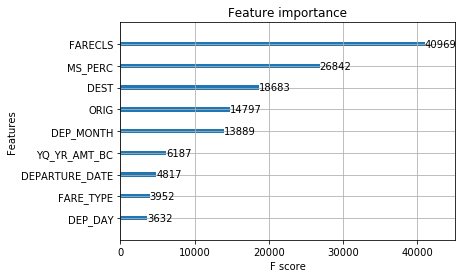

In [32]:
plot_importance(xgb_model)
plt.show()

In [26]:
df2 = df.drop(['DEPARTURE_DATE','DEP_DAY','FARE_TYPE'], axis=1)

In [27]:
X2 = df.drop(['FAREAMT_BC'], axis=1)
y2 = df['FAREAMT_BC']
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

In [28]:
eval_set = [(x2_test, y2_test)]
xgb_model2 = xgb.XGBRegressor(max_depth = 8,
                             silent = 1,
                             learning_rate = 0.3,
                             n_estimators = 600).fit(x2_train, y2_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
y2_pred = xgb_model2.predict(x2_test)
print("MSE: ", mean_squared_error(y2_test, y2_pred))
print("MAE: ", mean_absolute_error(y2_test, y2_pred))

[0]	validation_0-logloss:-41778.7
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:-41778.7
[2]	validation_0-logloss:-41778.7
[3]	validation_0-logloss:-41778.7
[4]	validation_0-logloss:-41778.7
[5]	validation_0-logloss:-41778.7
[6]	validation_0-logloss:-41778.7
[7]	validation_0-logloss:-41778.7
[8]	validation_0-logloss:-41778.7
[9]	validation_0-logloss:-41778.7
[10]	validation_0-logloss:-41778.7
Stopping. Best iteration:
[0]	validation_0-logloss:-41778.7

MSE:  17148.3706625
MAE:  94.6597006422
